In [2]:
# 보스턴 주택 가격 데이터 세트, 사이킷런 1.2ver 이후 삭제, 생성방법 변경

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
# from sklearn.datasets import load_boston # Removed due to ethical concerns
import warnings
warnings.filterwarnings('ignore')
# %matplotlib inline

# Load the Boston housing dataset from its original source
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep=r"\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

bostonDF = pd.DataFrame(data, columns = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'
]) # Re-add column names as they are not loaded by default
bostonDF['PRICE'] = target

print('Boston 데이터셋 크기 :',bostonDF.shape)
bostonDF.head()

Boston 데이터셋 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


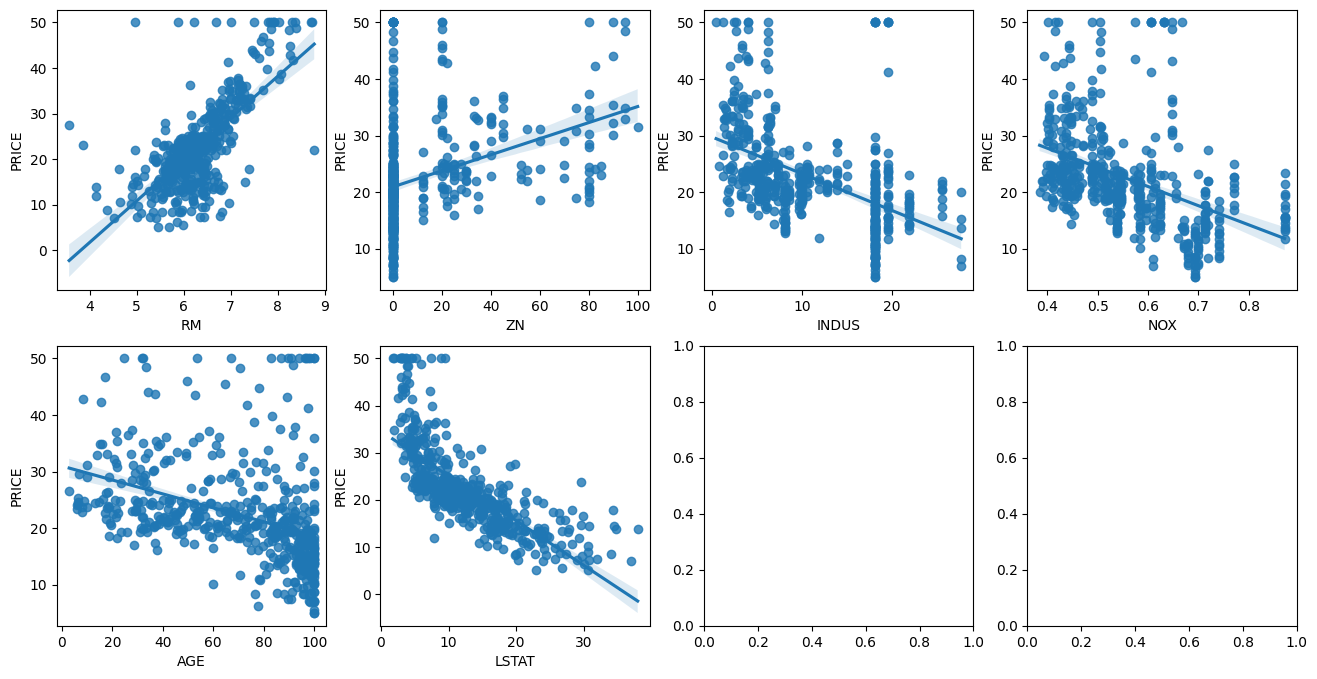

In [3]:
# 2개의 행과 4개의 열을 가진 subplots를 이용, axs는 4x2개의 ax를 가진다.
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
lm_features = ['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'LSTAT']
for i, feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])
    # 끝 2개는 왜 안뜨지?

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

# 선형 회귀 OLS로 학습/예측/평가 수행.
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3F}'.format(mse, rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297, RMSE : 4.159
Variance score : 0.757


In [5]:
print('절편 값:',lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_, 1))

절편 값: 40.995595172164826
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [6]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 새성. 인덱스 칼럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_, 1), index=X_data.columns)
coeff.sort_values(ascending=False)

,0
RM,3.4
CHAS,3.0
RAD,0.4
ZN,0.1
INDUS,0.0
B,0.0
TAX,-0.0
AGE,0.0
CRIM,-0.1
LSTAT,-0.6


In [7]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)
lr = LinearRegression()

# cross_val_score()로 5 폴드 세트로 MSE를 구한 뒤 이를 기반으로 다시 RMSE 구한다.
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores  = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_Score(scoring="neg_mean_squared_error"로 반환된 값은 모두 음수)
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds 의 개별 RMSE scores :  [3.53 5.1  5.75 8.99 5.77]
 5 folds 의 평균 RMSE : 5.829 


In [8]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# 다항식으로 변환한 단항식 생성, [[0, 1] [2, 3]]의 2X2 행렬 생성
X = np.arange(4).reshape(2, 2)
print('일차 단항식 계수 feature:\n', X)

# degree=2 인 2nd 차항식으로 변환하기 위해 PolynomialFeatures를 이용해 변환
poly = PolynomialFeatures(degree=2)
poly.fit(X)
poly_ftr = poly.transform(X)
print('변환된 2차 다항식 계수 피처:\n', poly_ftr)

일차 단항식 계수 feature:
 [[0 1]
 [2 3]]
변환된 2차 다항식 계수 피처:
 [[1. 0. 1. 0. 0. 1.]
 [1. 2. 3. 4. 6. 9.]]


In [9]:
def polynomial_func(X):
  y = 1 + 2*X[:, 0] + 3*X[:, 0]**2 + 4*X[:, 1]**3
  return y

X = np.arange(4).reshape(2, 2)
print('일차 단항식 계수 feature:\n', X)
y = polynomial_func(X)
print('삼차 다항식 결정값: \n', y)

일차 단항식 계수 feature:
 [[0 1]
 [2 3]]
삼차 다항식 결정값: 
 [  5 125]


In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np

def polynomial_func(X):
  y = 1 + 2*X[:, 0] + 3*X[:, 0]**2 + 4*X[:, 1]**3
  return y

X = np.arange(4).reshape(2, 2)
y = polynomial_func(X)

# 3차 다항식 변환
# X는 (2, 2) 형태의 2개 샘플, 2개 피처 데이터이므로 그대로 PolynomialFeatures를 적용합니다.
poly_ftr = PolynomialFeatures(degree=3).fit_transform(X)
print('3차 다항식 계수 feature:\n', poly_ftr)

# LinearRegression에 3차 다항식 계수 feature와 3차 다항식 결정값으로 학습 후 회귀 계수 확인
model = LinearRegression()
model.fit(poly_ftr, y)
print('Polynomial 회귀 계수\n', np.round(model.coef_, 2))
print('Polynomial 회귀 Shape:', model.coef_.shape)

3차 다항식 계수 feature:
 [[ 1.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.  8. 12. 18. 27.]]
Polynomial 회귀 계수
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]
Polynomial 회귀 Shape: (10,)


In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np

def polynomial_func(X):
  y = 1 + 2*X[:, 0] + 3*X[:, 0]**2 + 4*X[:, 1]**3
  return y

# Pipeline 객체로 Streamline하게 Polynomial Feature 변환과 Linear Regression을 연결
model = Pipeline([('poly', PolynomialFeatures(degree=3)), ('linear', LinearRegression())])
X = np.arange(4).reshape(2, 2)
y = polynomial_func(X)
model = model.fit(X, y)

# Linear Regression 모델의 계수 확인
print('Polynomial 회귀 계수\n', np.round(model.named_steps['linear'].coef_, 2))

Polynomial 회귀 계수
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]



Degree 1 회귀 계수는 [-1.61] 입니다.
Degree 1 MSE는 0.4077289625098685 입니다.

Degree 4 회귀 계수는 [  0.47 -17.79  23.59  -7.26] 입니다.
Degree 4 MSE는 0.04320874987232064 입니다.

Degree 15 회귀 계수는 [-2.98293000e+03  1.03899390e+05 -1.87416123e+06  2.03716219e+07
 -1.44873283e+08  7.09315363e+08 -2.47065792e+09  6.24561050e+09
 -1.15676510e+10  1.56894936e+10 -1.54006023e+10  1.06457264e+10
 -4.91377530e+09  1.35919645e+09 -1.70380786e+08] 입니다.
Degree 15 MSE는 181238256.56423894 입니다.


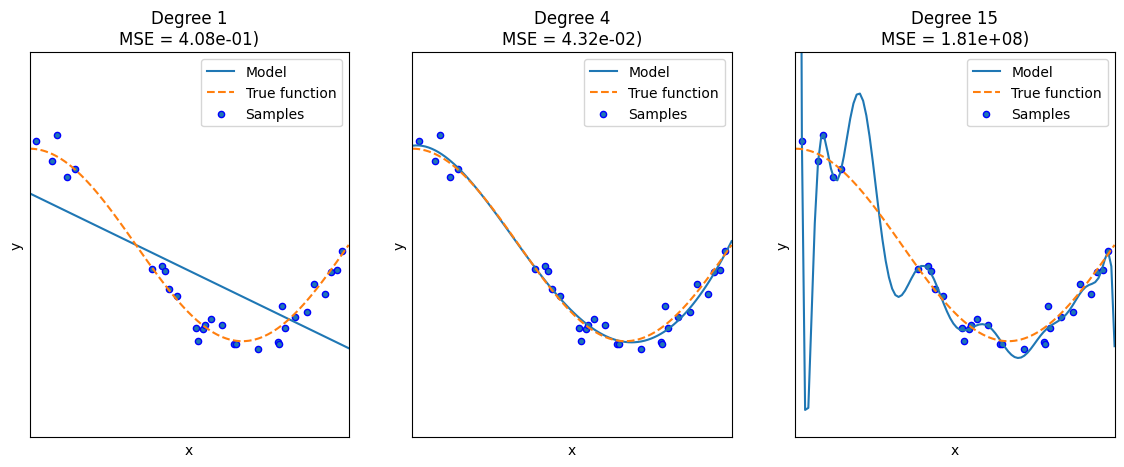

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
%matplotlib inline

# 임의의 값으로 구성된 X값에 대해 코사인 변환 값을 반환.
def true_fun(X):
  return np.cos(1.5 * np.pi * X)

# X는 0부터 1까지 30개의 임의의 값을 순서대로 샘플링한 데이터.
np.random.seed(0)
n_samples = 30
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
degrees = [1, 4, 15]

# 다항 회귀의 차수(degree)를 1, 4, 15로 각각 변화시키면서 비교.
for i in range(len(degrees)):
  ax = plt.subplot(1, len(degrees), i + 1)
  plt.setp(ax, xticks=(), yticks=())

  # 개별 degree별로 Polynomial 변환.
  polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
  linear_regression = LinearRegression()
  pipeline = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", linear_regression)])
  pipeline.fit(X.reshape(-1, 1), y)

  # 교차 검증으로 다항 회귀를 평가.
  scores = cross_val_score(pipeline, X.reshape(-1, 1), y, scoring="neg_mean_squared_error", cv=10)
  # Pipeline을 구성하는 세부 객체를 접근하는 named_steps['객체명']을 이용해 회귀계수 추출
  coefficients = pipeline.named_steps['linear_regression'].coef_
  print('\nDegree {0} 회귀 계수는 {1} 입니다.'.format(degrees[i], np.round(coefficients, 2)))
  print('Degree {0} MSE는 {1} 입니다.'.format(degrees[i], -1*np.mean(scores)))

  # 0부터 1까지 테스트 데이터 세트를 100개로 나눠 예측을 수행.
  # 테스트 데이터 세트에 회귀 예측을 수행하고 예측 곡선과 실제 곡선을 그려서 비교.
  X_test = np.linspace(0, 1, 100)
  # 예측 값 곡선
  plt.plot(X_test, pipeline.predict(X_test.reshape(-1, 1)), label="Model")
  # 실제 값 곡선
  plt.plot(X_test, true_fun(X_test), '--', label="True function")
  plt.scatter(X, y, edgecolor='b', s=20, label="Samples")

  plt.xlabel("x"); plt.ylabel("y"); plt.xlim((0, 1)); plt.ylim((-2, 2)); plt.legend(loc="best")
  plt.title("Degree {}\nMSE = {:.2e})".format(degrees[i], -scores.mean(), scores.std()))

plt.show()

In [13]:
# 보스턴 주택 가격 - > 캘리포니아 주택 가격 데이터로 치환.
# 사이킷런 1.2 이후 데이터 삭제

In [14]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# alpha=10으로 설정해 릿지 회귀 수행
ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores : ', np.round(rmse_scores, 3))
print(' 5 folds 의 평균 RMSE : {0:.3f} '.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-11.42 -24.29 -28.14 -74.6  -28.52]
 5 folds 의 개별 RMSE scores :  [3.38  4.929 5.305 8.637 5.34 ]
 5 folds 의 평균 RMSE : 5.518 


In [15]:
# 릿지에 사용될 alpha 파라미터의 값을 정의
alphas = [0, 0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse를 구한다.
for alpha in alphas :
  ridge = Ridge(alpha = alpha)

  # cross_val_scores를 이용해 5 폴드의 평균 RMSE 계산
  neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
  avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
  print('alpha {0} 일 때 5 folds의 평균 RMSE : {1:.3f} '.format(alpha, avg_rmse))

alpha 0 일 때 5 folds의 평균 RMSE : 5.829 
alpha 0.1 일 때 5 folds의 평균 RMSE : 5.788 
alpha 1 일 때 5 folds의 평균 RMSE : 5.653 
alpha 10 일 때 5 folds의 평균 RMSE : 5.518 
alpha 100 일 때 5 folds의 평균 RMSE : 5.330 


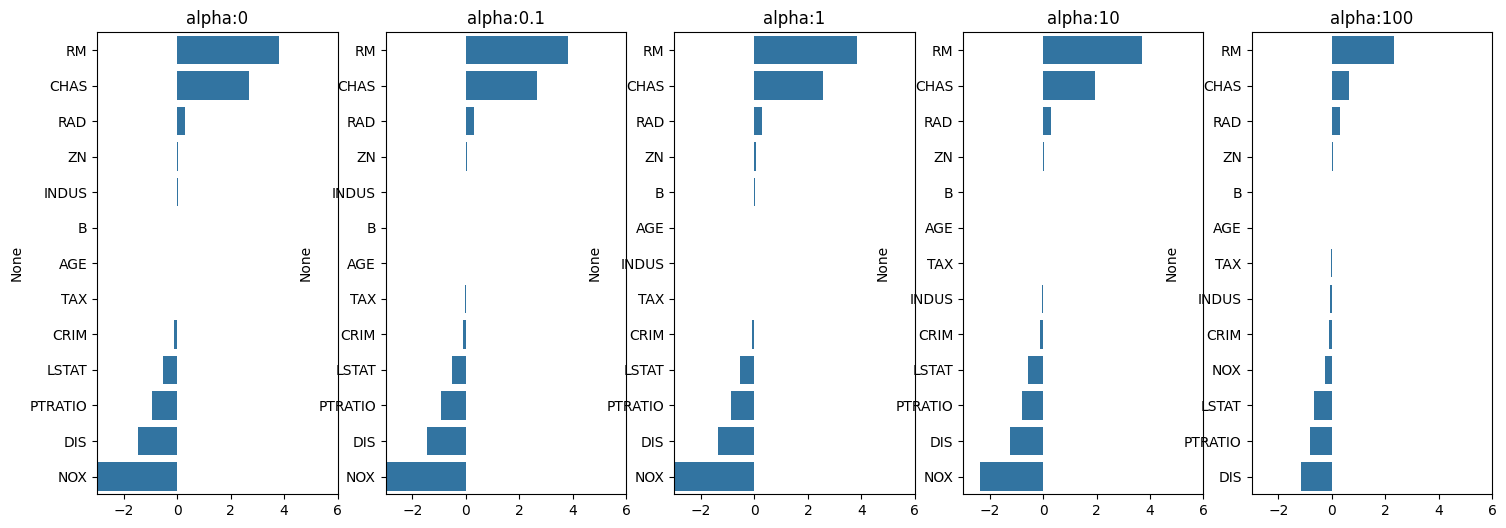

In [16]:
# 각 alpha에 따른 회귀 계수 값을 시가고하하기 위해 5개의 열로 된 맷플롯립 축 생성
fig, axs = plt.subplots(figsize=(18, 6), nrows=1, ncols=5)
# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기위한 DataFrame 생성
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos는 axis의 위치 지정
for pos, alpha in enumerate(alphas):
  ridge = Ridge(alpha = alpha)
  ridge.fit(X_data, y_target)
  # alpha에 따른 피처별로 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가.
  coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
  colname='alpha:'+str(alpha)
  coeff_df[colname] = coeff
  # 막대 그래프로 각 alpha값에서의 회귀 계수를 시가고하, 회귀 계수값이 높은 순으로 표현
  coeff = coeff.sort_values(ascending=False)
  axs[pos].set_title(colname)
  axs[pos].set_xlim(-3, 6)
  sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

#for 문 바깥에서 맷플롯립의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

In [17]:
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


In [18]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따른 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수값들을 DataFrame으로 변환
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True, return_coeff=True):
  coeff_df = pd.DataFrame()
  if verbose : print('#####', model_name, '#####')
  for param in params:
    if model_name == 'Ridge':model = Ridge(alpha=param)
    elif model_name == 'Lasso':model = Lasso(alpha=param)
    elif model_name == 'ElasticNet':model = ElasticNet(alpha=param, l1_ratio=0.7)
    neg_mse_scores = cross_val_score(model, X_data_n,
                                     y_target_n, scoring="neg_mean_squared_error", cv=5)
    avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
    print('alpha {0}일 때 5 폴드 세트의 평균 RMSE : {1:.3f}'.format(param, avg_rmse))
    # cross_val_score는 evaluation metric만 반환하므로 모델을 다시 학습하여 다시 회귀 계수 추출
    model.fit(X_data_n, y_target_n)
    if return_coeff:
      # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가
      coeff = pd.Series(data=model.coef_, index=X_data_n.columns)
      colname = 'alpha:'+str(param)
      coeff_df[colname] = coeff
  return coeff_df
# end of get_linear_regre_eval
# 라쏘에 사용될 alpha 파라미터의 값을 정의하고 get_linear_reg_eval()함수 호출
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas, X_data_n=X_data, y_target_n=y_target)

##### Lasso #####
alpha 0.07일 때 5 폴드 세트의 평균 RMSE : 5.612
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.615
alpha 0.5일 때 5 폴드 세트의 평균 RMSE : 5.669
alpha 1일 때 5 폴드 세트의 평균 RMSE : 5.776
alpha 3일 때 5 폴드 세트의 평균 RMSE : 6.189


In [19]:
# 반환된 coeff_lasso_df를 첫 번째 칼럼 순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


In [20]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params=elastic_alphas, X_data_n=X_data, y_target_n=y_target)

##### ElasticNet #####
alpha 0.07일 때 5 폴드 세트의 평균 RMSE : 5.542
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.526
alpha 0.5일 때 5 폴드 세트의 평균 RMSE : 5.467
alpha 1일 때 5 폴드 세트의 평균 RMSE : 5.597
alpha 3일 때 5 폴드 세트의 평균 RMSE : 6.068


In [21]:
# 반환된 coeff_elastic_df를 첫 번째 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


In [22]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures

# method는 표준 정규 분포 변환(Standard), 최댓값/최솟값 정규화(MinMax), 로그 변환(Log) 결정
# p_degree는 다항식 특성을 추가할 때 적용. p_degree는 2 이상 부여하지 않는다.
def get_scaled_data(method='None', p_degree=None, input_data=None):
  if method == 'Standard':
    scaled_data = StandardScaler().fit_transform(input_data)
  elif method == 'MinMax':
    scaled_data = MinMaxScaler().fit_transform(input_data)
  elif method == 'Log':
    scaled_data = np.log1p(input_data)
  else:
    scaled_data = input_data

  if p_degree != None:
    scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)

  return scaled_data
#

In [23]:
# Ridge의 alpha 값을 다르게 적용하고 다양한 데이터 변환 방법에 따른 RMSE 추출
alphas = [0.1, 1, 10, 100]

# 5개 방식으로 변환. 먼저 원본  그대로, 표준정규 분포, 표준정규 분포 + 다항식 특성
# 최대/최소 정규화, 최대/최소 정규화 + 다항식 특성, 로그 변환
scale_methods=[(None, None), ('Standard', None), ('Standard', 2), ('MinMax', None), ('MinMax', 2), ('Log', None)]
for scale_method in scale_methods:
  X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1], input_data=X_data)
  print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
  get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled, y_target_n=y_target, verbose=False, return_coeff=False)


## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.788
alpha 1일 때 5 폴드 세트의 평균 RMSE : 5.653
alpha 10일 때 5 폴드 세트의 평균 RMSE : 5.518
alpha 100일 때 5 폴드 세트의 평균 RMSE : 5.330

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.826
alpha 1일 때 5 폴드 세트의 평균 RMSE : 5.803
alpha 10일 때 5 폴드 세트의 평균 RMSE : 5.637
alpha 100일 때 5 폴드 세트의 평균 RMSE : 5.421

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 8.827
alpha 1일 때 5 폴드 세트의 평균 RMSE : 6.871
alpha 10일 때 5 폴드 세트의 평균 RMSE : 5.485
alpha 100일 때 5 폴드 세트의 평균 RMSE : 4.634

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.764
alpha 1일 때 5 폴드 세트의 평균 RMSE : 5.465
alpha 10일 때 5 폴드 세트의 평균 RMSE : 5.754
alpha 100일 때 5 폴드 세트의 평균 RMSE : 7.635

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE : 5.298
alpha 1일 때 5 폴드 세트의 평균 RMSE : 4.323
alpha 10일 때 5 폴드 세트의 평균 RMSE : 5.185
alpha 100일 때 5 폴드 세트의 평균 RMSE : 6.538

## 변환 유형:Log, Polynomial Degree:None
alpha 0.1일 때 5 폴

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# StandardScaler()로 평균이 0, 분산 1로 데이터 분포도 변환
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(data_scaled, cancer.target, test_size=0.3, random_state=0)


In [26]:
from sklearn.metrics import accuracy_score, roc_auc_score

# 로지스틱 회귀를 이용하여 학습 및 예측 수행
# solver 인자값을 생성자로 입력하지 않으면 solver='lbfgs'
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train) # Add this line to fit the model
lr_preds = lr_clf.predict(X_test)
lr_preds_proba = lr_clf.predict_proba(X_test)[:, 1]

# accuracy와 roc_auc 측정
print('accuracy: {0:3f}, roc_auc: {1:3f}'.format(accuracy_score(y_test, lr_preds), roc_auc_score(y_test, lr_preds_proba)))

accuracy: 0.976608, roc_auc: 0.994709


In [27]:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
# 여러 개의 solver 값 별로 LogisticRegression 학습 후 성능 평가
for solver in solvers:
  lr_clf = LogisticRegression(solver=solver, max_iter=600)
  lr_clf.fit(X_train, y_train)
  lr_preds = lr_clf.predict(X_test)
  lr_preds_proba = lr_clf.predict_proba(X_test)[:, 1]

  #accuracy와 roc_auc 측정
  print('solver:{0}, accuracy: {1:3f}, roc_auc:{2:.3f}'.format(solver,
                                                               accuracy_score(y_test, lr_preds),
                                                               roc_auc_score(y_test, lr_preds_proba)))

solver:lbfgs, accuracy: 0.976608, roc_auc:0.995
solver:liblinear, accuracy: 0.982456, roc_auc:0.995
solver:newton-cg, accuracy: 0.976608, roc_auc:0.995
solver:sag, accuracy: 0.982456, roc_auc:0.995
solver:saga, accuracy: 0.982456, roc_auc:0.995


In [28]:
from sklearn.model_selection import GridSearchCV

params = {'solver':['liblinear', 'lbfgs'],
          'penalty':['l2', 'l1'],
          'C':[0.01, 0.1, 1, 5, 10]}

lr_clf = LogisticRegression()

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3)
grid_clf.fit(data_scaled, cancer.target)
print('최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:3f}'.format(grid_clf.best_params_,
                                                 grid_clf.best_score_))

최적 하이퍼 파라미터:{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 최적 평균 정확도:0.978910


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.datasets import fetch_california_housing

# =========================
# California Housing 데이터 로드
# =========================
california = fetch_california_housing(as_frame=True)

X_data = california.data
y_target = california.target   # 주택 중위가격 (회귀 타겟)

# =========================
# RandomForestRegressor + 교차검증
# =========================
rf = RandomForestRegressor(
    random_state=0,
    n_estimators=1000,
    n_jobs=-1
)

neg_mse_scores = cross_val_score(
    rf,
    X_data,
    y_target,
    scoring="neg_mean_squared_error",
    cv=5
)

rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 교차 검증의 개별 Negative MSE scores:', np.round(neg_mse_scores, 2))
print('5 교차 검증의 개별 RMSE scores:', np.round(rmse_scores, 2))
print('5 교차 검증의 평균 RMSE : {0:.3f}'.format(avg_rmse))


5 교차 검증의 개별 Negative MSE scores: [-0.52 -0.34 -0.37 -0.44 -0.46]
5 교차 검증의 개별 RMSE scores: [0.72 0.59 0.61 0.66 0.68]
5 교차 검증의 평균 RMSE : 0.651


In [30]:
def get_model_cv_prediction_rmse(model, X_data, y_target):
  neg_mse_scores = cross_val_score(
      model,
      X_data,
      y_target,
      scoring="neg_mean_squared_error",
      cv=5)
  rmse_scores = np.sqrt(-1 * neg_mse_scores)
  avg_rmse = np.mean(rmse_scores)
  print('#####', model.__class__.__name__, '#####')
  print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

In [31]:
# =========================
# 1. 기본 import
# =========================
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# =========================
# 2. 데이터 로드
# =========================
california = fetch_california_housing(as_frame=True)

X_data = california.data
y_target = california.target

# =========================
# 3. RMSE 기반 CV 평가 함수
# =========================
def get_model_cv_prediction_rmse(model, X_data, y_target):
    neg_mse_scores = cross_val_score(
        model,
        X_data,
        y_target,
        scoring="neg_mean_squared_error",
        cv=3   # 공부용으로 3
    )
    rmse_scores = np.sqrt(-neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)

    print(f'{model.__class__.__name__}')
    print(f'RMSE scores: {np.round(rmse_scores, 3)}')
    print(f'Average RMSE: {avg_rmse:.3f}\n')
# =========================
# 4. 모델 정의 (속도 줄인 버전)
# =========================
dt_reg = DecisionTreeRegressor(
    random_state=0,
    max_depth=4
)

rf_reg = RandomForestRegressor(
    random_state=0,
    n_estimators=100,
    n_jobs=-1
)

gb_reg = GradientBoostingRegressor(
    random_state=0,
    n_estimators=100
)

xgb_reg = XGBRegressor(
    random_state=0,
    n_estimators=100,
    n_jobs=-1,
    objective='reg:squarederror'
)

lgb_reg = LGBMRegressor(
    random_state=0,
    n_estimators=100,
    n_jobs=-1
)
# =========================
# 5. 모델별 RMSE 비교
# =========================
models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]

for model in models:
    get_model_cv_prediction_rmse(model, X_data, y_target)


DecisionTreeRegressor
RMSE scores: [0.793 0.718 0.872]
Average RMSE: 0.794

RandomForestRegressor
RMSE scores: [0.715 0.572 0.733]
Average RMSE: 0.674

GradientBoostingRegressor
RMSE scores: [0.669 0.583 0.7  ]
Average RMSE: 0.651

XGBRegressor
RMSE scores: [0.678 0.565 0.77 ]
Average RMSE: 0.671

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 13760, number of used features: 8
[LightGBM] [Info] Start training from score 2.117384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 13760, number of used features: 8
[LightGBM] [Info] Start training from score 2.079973
[LightGBM] [Info] A

<Axes: xlabel='None', ylabel='None'>

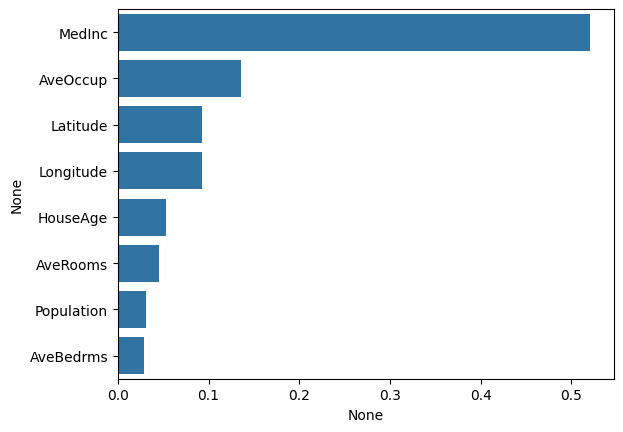

In [32]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators=100)

# 앞 예제에서 만들어진 X_data, y_target 데이터 세트를 적용해 학습.
rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)


(100, 2)


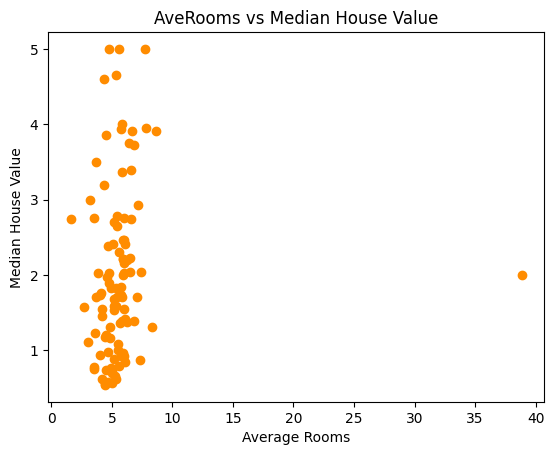

In [33]:
# California Housing 데이터 기준
californiaDF_sample = california.frame[['AveRooms', 'MedHouseVal']]
californiaDF_sample = californiaDF_sample.sample(n=100, random_state=0)

print(californiaDF_sample.shape)

plt.figure()
plt.scatter(
    californiaDF_sample['AveRooms'],
    californiaDF_sample['MedHouseVal'],
    c="darkorange"
)
plt.xlabel('Average Rooms')
plt.ylabel('Median House Value')
plt.title('AveRooms vs Median House Value')
plt.show()


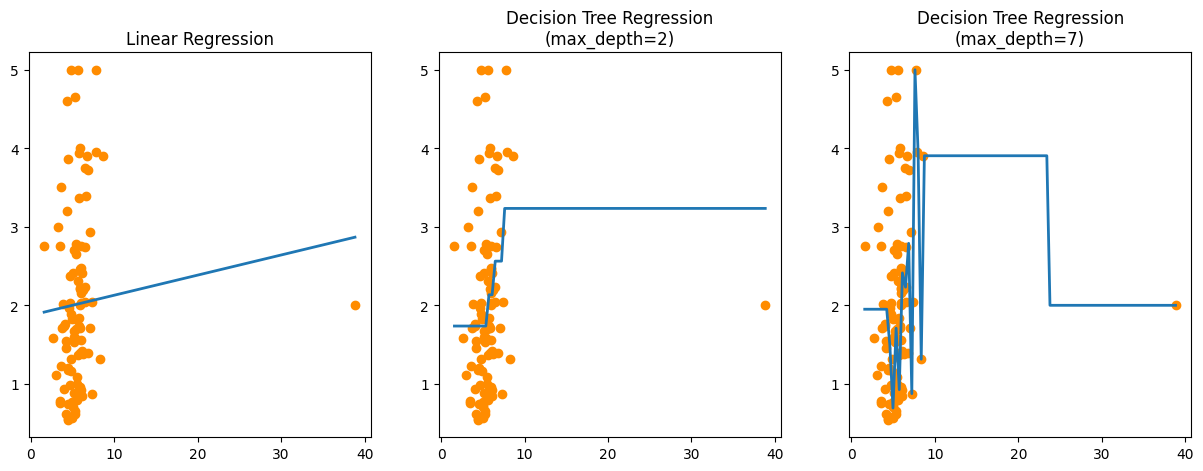

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import fetch_california_housing

# =========================
# 데이터 로드 및 샘플링
# =========================
california = fetch_california_housing(as_frame=True)
californiaDF = california.frame

californiaDF_sample = californiaDF.sample(n=100, random_state=0)

X_feature = californiaDF_sample['AveRooms'].values.reshape(-1, 1)
y_target = californiaDF_sample['MedHouseVal'].values.reshape(-1, 1)

# =========================
# 모델 생성
# =========================
lr_reg = LinearRegression()
dt_reg_depth2 = DecisionTreeRegressor(max_depth=2, random_state=0)
dt_reg_depth7 = DecisionTreeRegressor(max_depth=7, random_state=0)

# 테스트용 입력 데이터
X_test = np.linspace(
    X_feature.min(),
    X_feature.max(),
    100
).reshape(-1, 1)

# =========================
# 학습
# =========================
lr_reg.fit(X_feature, y_target)
dt_reg_depth2.fit(X_feature, y_target)
dt_reg_depth7.fit(X_feature, y_target)

# =========================
# 예측
# =========================
pred_lr = lr_reg.predict(X_test)
pred_dt_depth2 = dt_reg_depth2.predict(X_test)
pred_dt_depth7 = dt_reg_depth7.predict(X_test)

# =========================
# 시각화
# =========================
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 5), ncols=3)

ax1.set_title('Linear Regression')
ax1.scatter(X_feature, y_target, c="darkorange")
ax1.plot(X_test, pred_lr, linewidth=2)

ax2.set_title('Decision Tree Regression\n(max_depth=2)')
ax2.scatter(X_feature, y_target, c="darkorange")
ax2.plot(X_test, pred_dt_depth2, linewidth=2)

ax3.set_title('Decision Tree Regression\n(max_depth=7)')
ax3.scatter(X_feature, y_target, c="darkorange")
ax3.plot(X_test, pred_dt_depth7, linewidth=2)

plt.show()


In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

bike_df = pd.read_csv('/content/train_bike.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [36]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [37]:
# 문자열을 datetime 타입으로 변경
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)

bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


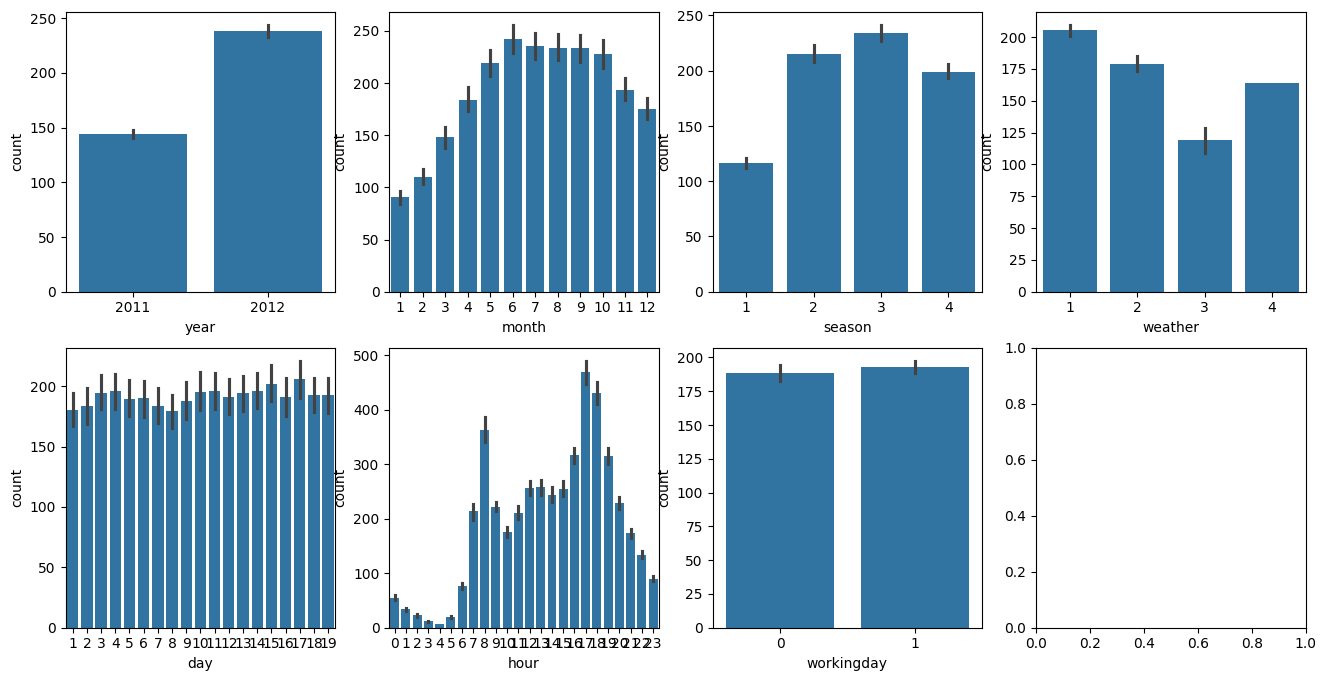

In [38]:
drop_columns = ['datetime', 'casual', 'registered']

# 컬럼이 존재하는지 확인하고, 존재하는 경우에만 삭제
columns_to_drop = [col for col in drop_columns if col in bike_df.columns]
if columns_to_drop:
    bike_df.drop(columns_to_drop, axis=1, inplace=True)

fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
cat_features = ['year', 'month', 'season', 'weather', 'day', 'hour', 'workingday']
for i, feature in enumerate(cat_features):
  row = int(i/4)
  col = i%4
  # 시본의 barplot을 이용해 칼럼값에 따른 count의 합을 표현
  sns.barplot(data=bike_df, x=feature, y='count', ax=axs[row][col])

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log()가 아닌, log1p()를 이용해 RMSLE 계산
def rmsle(y, pred):
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred) ** 2
  rmsle = np.sqrt(np.mean(squared_error))
  return rmsle

# 사이킷런의 mean_square_error()를 이용해 RMSE 계산
def rmse(y, pred):
  return np.sqrt(mean_squared_error(y, pred))

# MAE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y, pred):
  rmsle_val = rmsle(y, pred)
  rmse_val = rmse(y, pred)
  # MAE는 사이킷런의 mean_absolute_error()로 계산
  mae_val = mean_absolute_error(y, pred)
  print('RMSLE: {0:3f}, RMSE: {1:3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

In [40]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.164664, RMSE: 140.899589, MAE: 105.924


In [41]:
def get_top_error_data(y_test, pred, n_tops = 5):
  # DataFrame의 칼럼으로 실제 대여 횟수(count)와 예측값을 서로 비교할 수 있도록 생성.
  result_df = pd.DataFrame(y_test.values, columns=['real_count'])
  result_df['predicted_count'] = np.round(pred)
  result_df['diff'] = np.abs(result_df['predicted_count'] - result_df['real_count'])

  # 예측값과 실제 값이 가장 큰 데이터 순으로 출력.
  print(result_df.sort_values('diff', ascending=False)[:n_tops])
get_top_error_data(y_test, pred, n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
966          884            327.0  557.0
3151         798            241.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<Axes: >

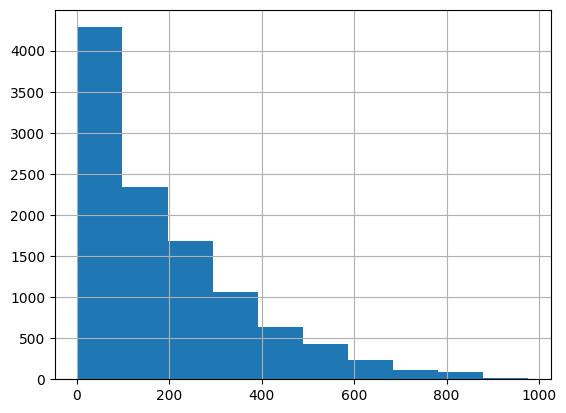

In [42]:
y_target.hist()

<Axes: >

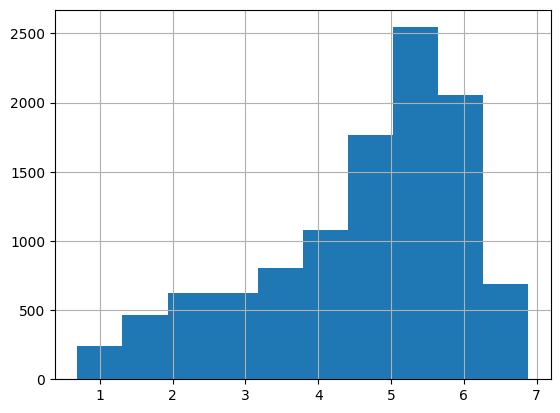

In [43]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [44]:
# 타깃 칼럼인 count인 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 데이터 세트 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

# 테스트 데이터 세트의 Target 값은 로그 변환됐으므로 다시 expm1을 이용해 원래 스케일로 변환
y_test_exp = np.expm1(y_test)

# 예측 값 역시 로그 변환된 타깃 기반으로 학습돼 예측됐으므로 다시 expm1로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.016827, RMSE: 162.594268, MAE: 109.286


<Axes: ylabel='None'>

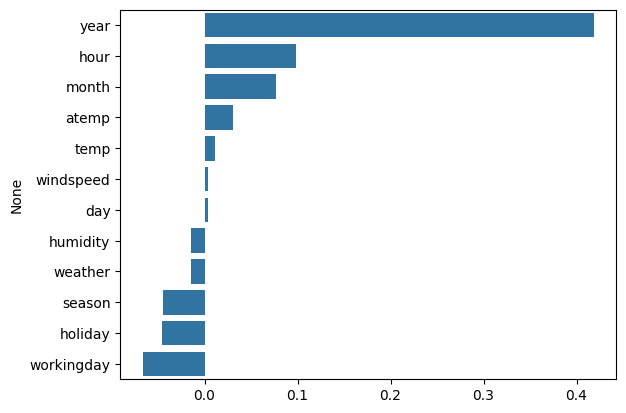

In [45]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [46]:
# 'year', 'month', 'day', 'hour 등의 피처들을 One Hot Encoding
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month', 'day', 'hour', 'season', 'weather', 'workingday'])

In [47]:
# 원-핫 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  if is_expm1 :
    y_test = np.expm1(y_test)
    pred = np.expm1(pred)
  print('###', model.__class__.__name__, '###')
  evaluate_regr(y_test, pred)
  return pred
  # end of function get_model_predict

# 모델 별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
  get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.589634, RMSE: 97.687643, MAE: 63.382
### Ridge ###
RMSLE: 0.590139, RMSE: 98.527906, MAE: 63.893
### Lasso ###
RMSLE: 0.634752, RMSE: 113.218805, MAE: 72.803


<Axes: ylabel='None'>

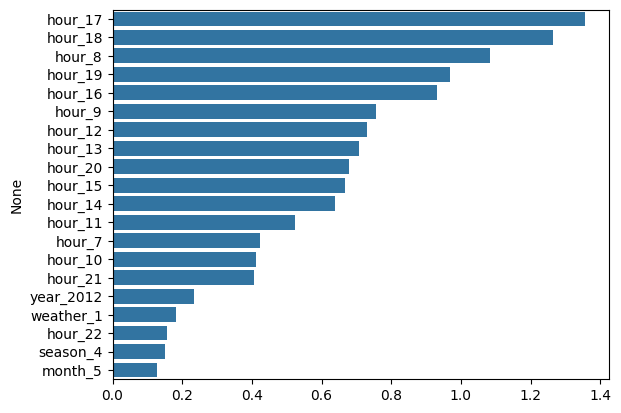

In [48]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [49]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM model 별로 평가 수행
rf_reg = RandomForestRegressor(random_state=0, n_estimators=500)
gbm_reg = GradientBoostingRegressor(random_state=0, n_estimators=500)
xgb_reg = XGBRegressor(random_state=0, n_estimators=500)
lgbm_reg = LGBMRegressor(random_state=0, n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
  # XGBoost의 경우 DataFrame이 입력될 경우 버전에 따라 오류 발생 가능 .ndarray로 변환
  get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values,is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.354576, RMSE: 50.318265, MAE: 31.128
### GradientBoostingRegressor ###
RMSLE: 0.329845, RMSE: 53.329191, MAE: 32.737
### XGBRegressor ###
RMSLE: 0.338834, RMSE: 51.486562, MAE: 31.372
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 71
[LightGBM] [Info] Start training from score 4.582043
### LGBMRegressor ###
RMSLE: 0.318846, RMSE: 47.214647, MAE: 29.029


In [50]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('/content/train_house.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [51]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n 전체 피처의 type \n', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 칼럼과 그 건수:\n', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

 전체 피처의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 칼럼과 그 건수:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


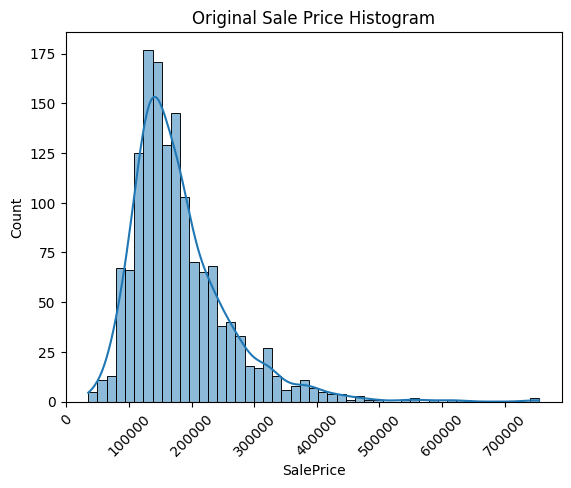

In [52]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=45)
sns.histplot(house_df['SalePrice'], kde=True)
plt.show()

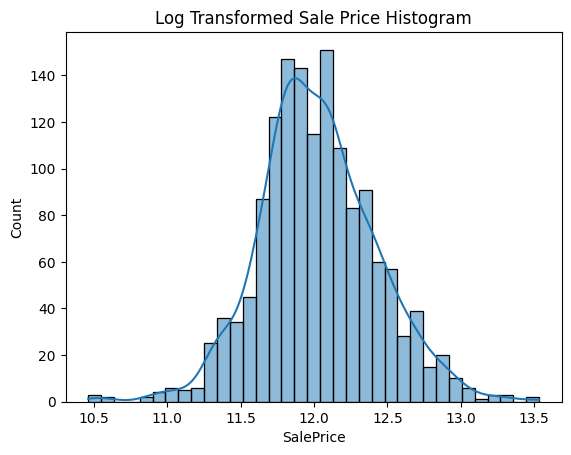

In [53]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

In [54]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null이 너무 많은 칼럼과 불필요한 칼럼 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True, errors='ignore')

# 숫자형 Null 칼럼은 평균값으로 대체
numeric_cols = house_df.select_dtypes(include=np.number).columns
house_df[numeric_cols] = house_df[numeric_cols].fillna(house_df[numeric_cols].mean())

# Categorical Null 칼럼은 'None'으로 대체
categorical_cols = house_df.select_dtypes(exclude=np.number).columns
for col in categorical_cols:
    if house_df[col].isnull().sum() > 0:
        house_df[col] = house_df[col].fillna('None')

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 Series([], dtype: object)


In [55]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df.shape)

null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 75)
## Null 피처의 Type :
 Series([], dtype: object)


In [56]:
def get_rmse(model):
  pred = model.predict(X_test)
  mse = mean_squared_error(y_test, pred)
  rmse = np.sqrt(mse)
  print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse, 3))
  return rmse

def get_rmses(models):
  rmses = []
  for model in models:
    rmse = get_rmse(model)
    rmses.append(rmse)
  return rmses

In [57]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso  학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[np.float64(0.13183184688244023),
 np.float64(0.12755732495458433),
 np.float64(0.17628250556471403)]

In [58]:
def get_top_bottom_coef(model, n=10):
  # coef_ 속성을 기반으로 Series 객체를 생성. index는 칼럼명.
  coef = pd.Series(model.coef_, index=X_features.columns)

  # + 상위 10개, - 하위 10개의 회귀 계수를 추출해 반환.
  coef_high = coef.sort_values(ascending=False).head(n)
  coef_low = coef.sort_values(ascending=False).tail(n)
  return coef_high, coef_low

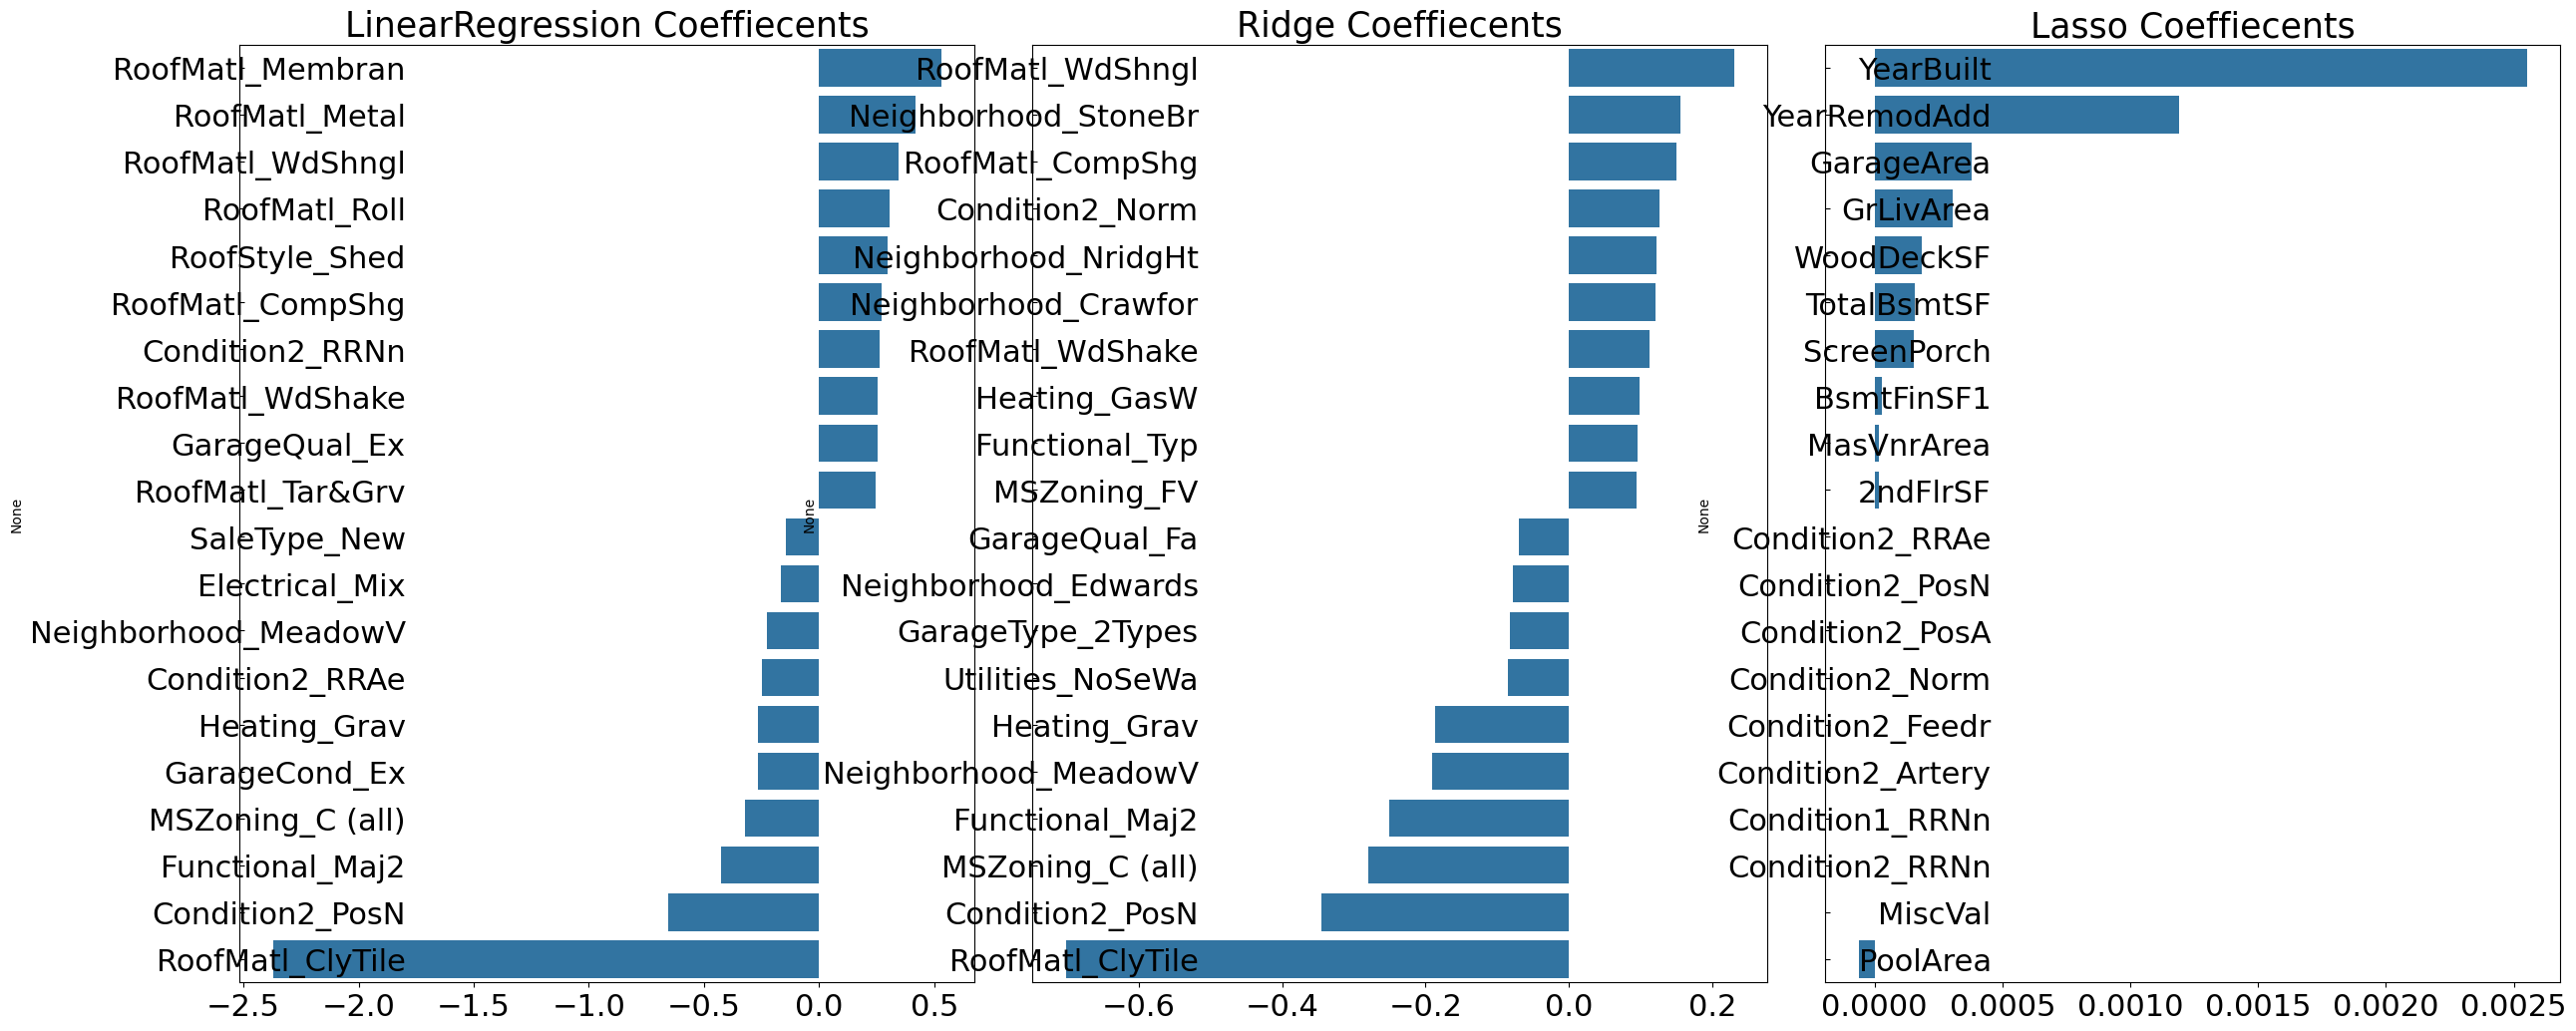

In [59]:
def visualize_coefficient(models):
  # 3개의 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
  fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
  fig.tight_layout()
  # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화
  for i_num, model in enumerate(models):
    # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합.
    coef_high, coef_low = get_top_bottom_coef(model)
    coef_concat = pd.concat([coef_high, coef_low])
    # ax subplot에 barchar로 표현, 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정
    axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
    axs[i_num].tick_params(axis="y", direction="in", pad=-120)
    for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
      label.set_fontsize(22)
    sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [60]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
  for model in models:
    # 분할하지 않고, 전체 데이터로 cross_val_score() tngod, 모델별 CV RMSE 값과 평균 RMSE 출력
    rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring="neg_mean_squared_error", cv=5))
    rmse_avg = np.mean(rmse_list)
    print('\n{0} CV RMSE 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
    print('{0} CV 평균 RMSE: {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))\

# 앞 예제에서 학습한 ridge_reg, lasso_reg 모델의 CV RMSE 값 출력
models = [ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


Ridge CV RMSE 리스트: [0.117 0.155 0.142 0.117 0.189]
Ridge CV 평균 RMSE: 0.144

Lasso CV RMSE 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE: 0.198


In [61]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
  grid_model = GridSearchCV(model, param_grid=params,
                            scoring='neg_mean_squared_error', cv=5)
  grid_model.fit(X_features, y_target)
  rmse = np.sqrt(-1*grid_model.best_score_)
  print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                                           np.round(rmse, 4), grid_model.best_params_))
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값:0.142, 최적 alpha:{'alpha': 0.001}


=== 모델별 RMSE ===
LinearRegression : 0.132
Ridge           : 0.124
Lasso           : 0.120


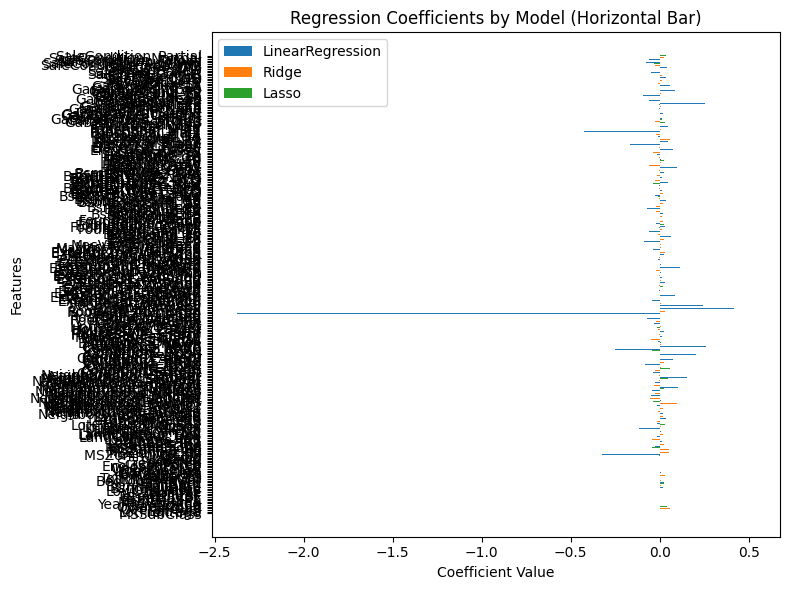

In [67]:
# 앞의 최적화 alpha 값으로 학습 데이터로 학습, 테스트 데이터로 예측 및 평가 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [69]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 칼럼 index를 []로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew() 호출
skew_features = house_df[features_index].apply(lambda x : skew(x))

# skew(왜곡) 정도 1 이상인 칼럼 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [70]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [72]:
# 왜곡 정도가 높은 피처를 로그 변환했으므로 다시 원-핫 인코딩을 적용하고 피쳐/타깃 데이터 세트 생성
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1274, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1252, 최적 alpha:{'alpha': 0.001}


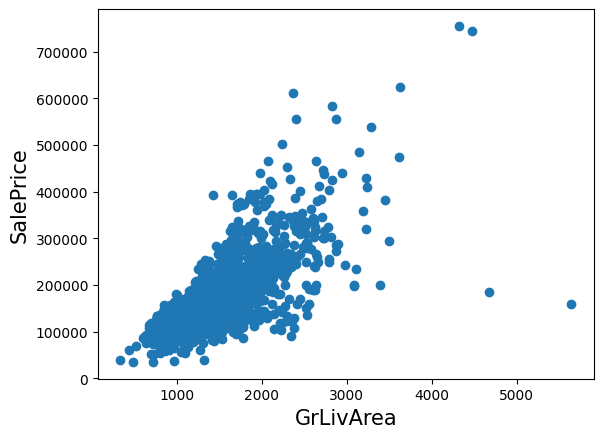

In [73]:
plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [74]:
# GrLivArea와 SalePrice 모두 로그 변환됐으므로 이를 반영한 조건 생성.
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('이상치 레코드 index:', outlier_index.values)
print('이상치 삭제 전 house_df_ohe.shape:', house_df_ohe.shape)

# DataFrame의 인덱스를 이용해 이상치 레코드 삭제
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe.shape:', house_df_ohe.shape)

이상치 레코드 index: [ 523 1298]
이상치 삭제 전 house_df_ohe.shape: (1460, 281)
이상치 삭제 후 house_df_ohe.shape: (1458, 281)


In [75]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1122, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1122, 최적 alpha:{'alpha': 0.001}


In [76]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값:0.1205, 최적 alpha:{'n_estimators': 1000}


In [78]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, colsample_bytree=0.4, subsample=0.6, reg_lambda=10, n_jobs=1)
print_best_params(lgbm_reg, lgbm_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3175
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 181
[LightGBM] [Info] Start training from score 12.021352
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3187
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 178
[LightGBM] [Info] Start training from score 12.023516
[LightGBM] [Warning] Found

In [ ]:
def get_rmse_pred